# __Ocean regimes indicator__

Apply a Gaussian Mixtures Model to a dataset of time series

***
ds : initial dataset (lat, lon, week)

X : staked dataset (sampling, week, week_reduced)

ds_labels: unstacked final dataset (lat, lon, week)
***

In [1]:
import xarray as xr
import numpy as np
import pandas as pd

import Plotter_OR
from Plotter_OR import Plotter_OR 

from BIC_calculation_OR import *

## Load dataset
***

- One year of SST data in the Mediterranean Sea:  SST_GLO_SST_L4_NRT_OBSERVATIONS_010_014 product

In [2]:
file_path = 'datasets/METOFFICE-GLO-SST-L4-NRT-OBS-SKIN-DIU-FV01.1_1607013925530.nc'

- One year of SST data in the North Atlantic:  SST_GLO_SST_L4_NRT_OBSERVATIONS_010_014 product

In [3]:
#file_path = 'datasets/METOFFICE-GLO-SST-L4-NRT-OBS-SKIN-DIU-FV01.1_1608215256580.nc'

- One year of Ocean Color data in the Mediterranean Sea:  OCEANCOLOUR_GLO_CHL_L4_REP_OBSERVATIONS_009_082 product

In [4]:
#file_path = 'datasets/dataset-oc-glo-bio-multi-l4-chl_interpolated_4km_daily-rep_1610026811620.nc'

Open dataset

In [5]:
ds = xr.open_dataset(file_path)
print(ds)
#ds

<xarray.Dataset>
Dimensions:                                        (lat: 65, lon: 192, time: 8760)
Coordinates:
  * time                                           (time) datetime64[ns] 2019-01-01T00:30:00 ... 2019-12-31T23:30:00
  * lat                                            (lat) float32 30.125 ... 46.125
  * lon                                            (lon) float32 -4.875 ... 42.875
Data variables:
    sea_surface_warm_layer_temperature_difference  (time, lat, lon) float32 ...
    sea_surface_cool_skin_temperature_difference   (time, lat, lon) float32 ...
    analysed_sst                                   (time, lat, lon) float32 ...
    mask                                           (time, lat, lon) float32 ...
Attributes:
    Conventions:                CF-1.4
    title:                      Global Diurnal Skin SST Analysis, L4 OSTIA, 0...
    summary:                    A merged, multi-sensor L4 skin SST product
    references:                 While J., Martin M.; 2013;  D

In [6]:
#important to identify time variable
#ds['time'] = ds.indexes['time'].to_datetimeindex()
var_name = 'analysed_sst'

__Quick plot__

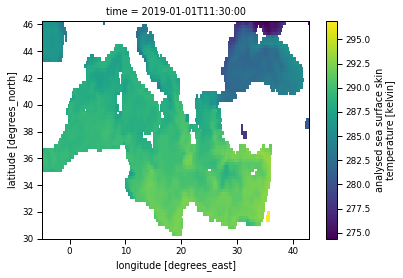

In [7]:
ds[var_name].isel(time=11).plot();

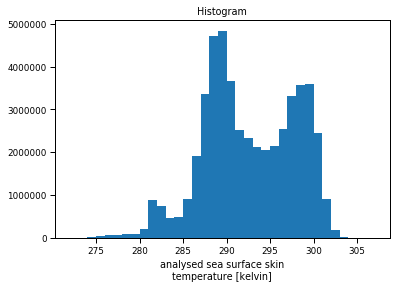

In [8]:
bins = np.arange(int(ds[var_name].min().values), int(ds[var_name].max().values))
ds[var_name].plot.hist(bins=bins);

## Preprocessing
***

#### __1) Weekly mean for each pixel__

Weekly mean is useful for seasonal trends (lisser le signal): should it be an option?

In [9]:
X = ds.groupby("time.week").mean()
print(X)

/export/home1/agarciaj/anaconda3/lib/python3.7/site-packages/xarray/core/accessor_dt.py:45: FutureWarning: Series.dt.weekofyear and Series.dt.week have been deprecated.  Please use Series.dt.isocalendar().week instead.
  field_values = getattr(values_as_series.dt, name).values
/export/home1/agarciaj/anaconda3/lib/python3.7/site-packages/xarray/core/nanops.py:142: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis=axis, dtype=dtype)


<xarray.Dataset>
Dimensions:                                        (lat: 65, lon: 192, week: 52)
Coordinates:
  * lat                                            (lat) float32 30.125 ... 46.125
  * lon                                            (lon) float32 -4.875 ... 42.875
  * week                                           (week) int64 1 2 3 ... 51 52
Data variables:
    sea_surface_warm_layer_temperature_difference  (week, lat, lon) float32 nan ... 0.0
    sea_surface_cool_skin_temperature_difference   (week, lat, lon) float32 nan ... 0.0
    analysed_sst                                   (week, lat, lon) float32 nan ... 275.3912
    mask                                           (week, lat, lon) float32 2.0 ... 1.0


Plot histogram in time: in plotter class?

Text(0, 0.5, 'Counts')

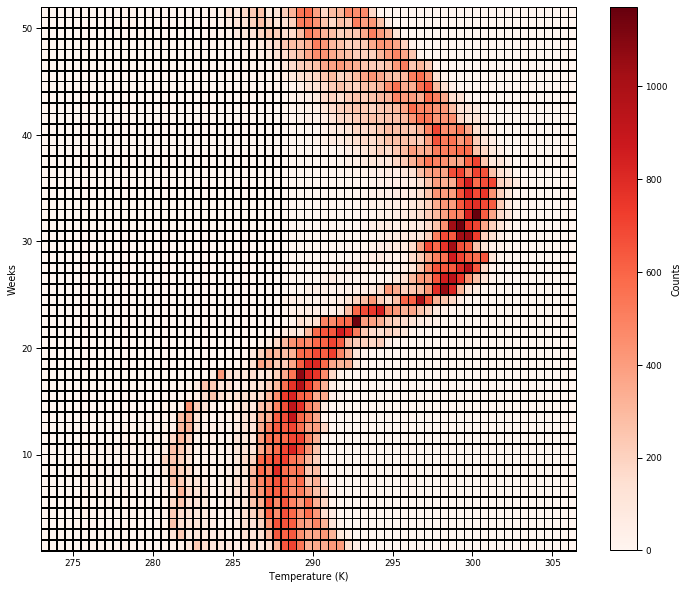

In [10]:
bins = np.arange(int(X[var_name].min().values), int(X[var_name].max().values),0.5)
#bins = np.arange(0, 0.3, 0.002)
histo_2d = [] 
for iweek in range(52):
#for iweek in range(12):
    hist_values, bin_edges = np.histogram(X[var_name].isel(week=iweek).values, bins=bins)
    #hist_values, bin_edges = np.histogram(ds[var_name].isel(month=iweek).values, bins=bins)
    histo_2d.append(hist_values)
    
fig, ax = plt.subplots(figsize=(12,10))

#plt.pcolormesh(bins, ds.month.values, histo_2d, cmap='Reds', edgecolors='black')
plt.pcolormesh(bins, X.week.values, histo_2d, cmap='Reds', edgecolors='black')
cbar = plt.colorbar()
ax.set_xlabel('Temperature (K)')
#ax.set_xlabel('Chlorophyll-a concentration (milligram m-3)')
ax.set_ylabel('Weeks')
cbar.ax.set_ylabel('Counts')

#### __2) Reduce lat lon dimensions to sampling dimension__

In [11]:
sampling_dims = list(X.dims)
sampling_dims.remove('week')
sampling_dims

['lat', 'lon']

In [12]:
X = X.stack({'sampling': sampling_dims})
X = X.rename_dims({'week': 'feature'})
X = X.rename({'week': 'feature'})
print(X)
#X

<xarray.Dataset>
Dimensions:                                        (feature: 52, sampling: 12480)
Coordinates:
  * feature                                        (feature) int64 1 2 ... 51 52
  * sampling                                       (sampling) MultiIndex
  - lat                                            (sampling) float64 30.12 ... 46.12
  - lon                                            (sampling) float64 -4.875 ... 42.88
Data variables:
    sea_surface_warm_layer_temperature_difference  (feature, sampling) float32 nan ... 0.0
    sea_surface_cool_skin_temperature_difference   (feature, sampling) float32 nan ... 0.0
    analysed_sst                                   (feature, sampling) float32 nan ... 275.3912
    mask                                           (feature, sampling) float32 2.0 ... 1.0


#### __3) Delate all NaN time series using mask__

Create mask from data

In [13]:
mask_d = X[var_name].notnull()
X = X.assign(variables={"mask_d":(('feature','sampling'), mask_d)})
print(X)
#X

<xarray.Dataset>
Dimensions:                                        (feature: 52, sampling: 12480)
Coordinates:
  * feature                                        (feature) int64 1 2 ... 51 52
  * sampling                                       (sampling) MultiIndex
  - lat                                            (sampling) float64 30.12 ... 46.12
  - lon                                            (sampling) float64 -4.875 ... 42.88
Data variables:
    sea_surface_warm_layer_temperature_difference  (feature, sampling) float32 nan ... 0.0
    sea_surface_cool_skin_temperature_difference   (feature, sampling) float32 nan ... 0.0
    analysed_sst                                   (feature, sampling) float32 nan ... 275.3912
    mask                                           (feature, sampling) float32 2.0 ... 1.0
    mask_d                                         (feature, sampling) bool False ... True


Plot created mask

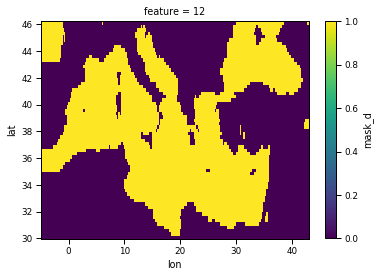

In [14]:
mask_plot = X['mask_d'].unstack('sampling')
#.sortby(['lat','lon'])
mask_plot.isel(feature=11).plot();

Apply mask 

In [15]:
stacked_mask = X['mask_d']
print(stacked_mask)
#stacked_mask

<xarray.DataArray 'mask_d' (feature: 52, sampling: 12480)>
array([[False, False, False, ..., False, False,  True],
       [False, False, False, ..., False, False,  True],
       [False, False, False, ..., False, False,  True],
       ...,
       [False, False, False, ..., False, False,  True],
       [False, False, False, ..., False, False,  True],
       [False, False, False, ..., False, False,  True]])
Coordinates:
  * feature   (feature) int64 1 2 3 4 5 6 7 8 9 ... 44 45 46 47 48 49 50 51 52
  * sampling  (sampling) MultiIndex
  - lat       (sampling) float64 30.12 30.12 30.12 30.12 ... 46.12 46.12 46.12
  - lon       (sampling) float64 -4.875 -4.625 -4.375 ... 42.38 42.62 42.88


In [16]:
X = X[var_name].where(stacked_mask == True, drop=True).to_dataset()
print(X)
#X

<xarray.Dataset>
Dimensions:       (feature: 52, sampling: 5741)
Coordinates:
  * feature       (feature) int64 1 2 3 4 5 6 7 8 9 ... 45 46 47 48 49 50 51 52
  * sampling      (sampling) MultiIndex
  - lat           (sampling) float64 30.38 30.38 30.38 ... 46.12 46.12 46.12
  - lon           (sampling) float64 18.62 18.88 19.12 ... 38.38 38.62 42.88
Data variables:
    analysed_sst  (feature, sampling) float32 291.3304 291.29144 ... 275.3912


Recover the dataset (unravel)

In [17]:
X_unstacked = X[var_name].unstack('sampling').to_dataset(name = var_name)
X_unstacked = X_unstacked.sortby(['lat','lon'])
print(np.shape(X_unstacked[var_name]))
# same lat and lon values in mask and in results
mask = stacked_mask.unstack()
X_unstacked = X_unstacked.reindex_like(mask)
print(np.shape(X_unstacked[var_name]))
print(X_unstacked) 

(52, 64, 191)
(52, 65, 192)
<xarray.Dataset>
Dimensions:       (feature: 52, lat: 65, lon: 192)
Coordinates:
  * lat           (lat) float64 30.12 30.38 30.62 30.88 ... 45.62 45.88 46.12
  * lon           (lon) float64 -4.875 -4.625 -4.375 ... 42.38 42.62 42.88
  * feature       (feature) int64 1 2 3 4 5 6 7 8 9 ... 45 46 47 48 49 50 51 52
Data variables:
    analysed_sst  (feature, lat, lon) float32 nan nan nan ... nan nan 275.3912


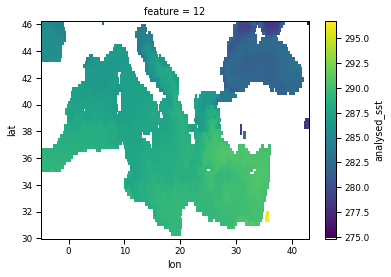

In [18]:
X_unstacked[var_name].isel(feature=11).plot();

__There is any NaN in the dataset?__

In [19]:
np.any(np.isnan(X[var_name].values))

False

#### __4) Interpolation__

Not necessary if using mask created from dataset

In [20]:
X = X[var_name].interpolate_na(dim = 'feature', method="linear", fill_value="extrapolate").to_dataset(name = var_name)
print(X)
#X

<xarray.Dataset>
Dimensions:       (feature: 52, sampling: 5741)
Coordinates:
  * feature       (feature) int64 1 2 3 4 5 6 7 8 9 ... 45 46 47 48 49 50 51 52
  * sampling      (sampling) MultiIndex
  - lat           (sampling) float64 30.38 30.38 30.38 ... 46.12 46.12 46.12
  - lon           (sampling) float64 18.62 18.88 19.12 ... 38.38 38.62 42.88
Data variables:
    analysed_sst  (feature, sampling) float32 291.3304 291.29144 ... 275.3912


__There is any NaN in the dataset?__

In [21]:
np.any(np.isnan(X[var_name].values))

False

#### __5) Scaler__

__Check dimensions order__
***

In [22]:
np.shape(X[var_name])

(52, 5741)

Transpose dataset if needed (sampling x features)

In [23]:
X = X.transpose("sampling", "feature")
np.shape(X[var_name].values)

(5741, 52)

***

Apply sklearn __StandardScaler__: 
Standardize features by removing the mean and scaling to unit variance
The standard score of a sample x is calculated as:

    z = (x - u) / s
    
where u is the mean of the training samples or zero if `with_mean=False`, and s is the standard deviation of the training samples or one if `with_std=False`.
Centering and scaling happen independently on each feature by computing the relevant statistics on the samples in the training set. 

In [24]:
from sklearn.preprocessing import StandardScaler
X_scale = StandardScaler().fit_transform(X[var_name])
X = X.assign(variables={var_name + "_scaled":(('sampling', 'feature'), X_scale)})
print(X)
#X

<xarray.Dataset>
Dimensions:              (feature: 52, sampling: 5741)
Coordinates:
  * feature              (feature) int64 1 2 3 4 5 6 7 ... 46 47 48 49 50 51 52
  * sampling             (sampling) MultiIndex
  - lat                  (sampling) float64 30.38 30.38 30.38 ... 46.12 46.12
  - lon                  (sampling) float64 18.62 18.88 19.12 ... 38.62 42.88
Data variables:
    analysed_sst         (sampling, feature) float32 291.3304 ... 275.3912
    analysed_sst_scaled  (sampling, feature) float32 0.98910934 ... -4.903476


#### __5) PCA__

Apply __Principal component analysis__ (PCA):
Linear dimensionality reduction using Singular Value Decomposition of the data to project it to a lower dimensional space.
If `0 < n_components < 1` and `svd_solver == 'full'`, select the number of components such that the amount of variance that needs to be explained is greater than the percentage specified by n_components.

In [25]:
from sklearn.decomposition import PCA
pca = PCA(n_components = 0.99, svd_solver = 'full')
pca

PCA(copy=True, iterated_power='auto', n_components=0.99, random_state=None,
    svd_solver='full', tol=0.0, whiten=False)

In [26]:
pca = pca.fit(X[var_name + "_scaled"])

Text(0.5, 1.0, 'Percentage of variance explained by each of the selected components')

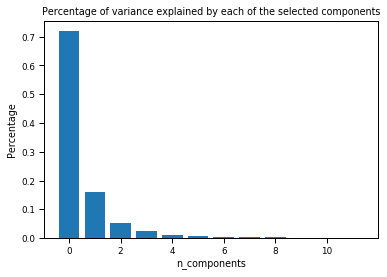

In [27]:
fig, ax = plt.subplots()
pb = plt.bar(range(pca.n_components_), pca.explained_variance_ratio_)
ax.set_xlabel('n_components')
ax.set_ylabel('Percentage')
ax.set_title('Percentage of variance explained by each of the selected components')

In [28]:
X_reduced = pca.transform(X[var_name + "_scaled"])
np.shape(X_reduced)

(5741, 12)

In [29]:
X = X.assign(variables={var_name + "_reduced":(('sampling', 'feature_reduced'),X_reduced)})
print(X)

<xarray.Dataset>
Dimensions:               (feature: 52, feature_reduced: 12, sampling: 5741)
Coordinates:
  * feature               (feature) int64 1 2 3 4 5 6 7 ... 46 47 48 49 50 51 52
  * sampling              (sampling) MultiIndex
  - lat                   (sampling) float64 30.38 30.38 30.38 ... 46.12 46.12
  - lon                   (sampling) float64 18.62 18.88 19.12 ... 38.62 42.88
Dimensions without coordinates: feature_reduced
Data variables:
    analysed_sst          (sampling, feature) float32 291.3304 ... 275.3912
    analysed_sst_scaled   (sampling, feature) float32 0.98910934 ... -4.903476
    analysed_sst_reduced  (sampling, feature_reduced) float32 6.956739 ... 0.32258075


## Apply Model
***

__Create model__

In [30]:
from sklearn import mixture
k = 7 # number of classes
model = mixture.GaussianMixture(n_components=k, covariance_type='full')
model

GaussianMixture(covariance_type='full', init_params='kmeans', max_iter=100,
                means_init=None, n_components=7, n_init=1, precisions_init=None,
                random_state=None, reg_covar=1e-06, tol=0.001, verbose=0,
                verbose_interval=10, warm_start=False, weights_init=None)

__Fit model__

In [31]:
model.fit(X[var_name + "_reduced"])

GaussianMixture(covariance_type='full', init_params='kmeans', max_iter=100,
                means_init=None, n_components=7, n_init=1, precisions_init=None,
                random_state=None, reg_covar=1e-06, tol=0.001, verbose=0,
                verbose_interval=10, warm_start=False, weights_init=None)

__Predict labels__

In [32]:
X_labels = model.predict(X[var_name + "_reduced"])
X_labels

array([5, 5, 5, ..., 0, 0, 0])

In [33]:
X = X.assign(variables={"GMM_labels":(('sampling'),X_labels)})
print(X)
#X

<xarray.Dataset>
Dimensions:               (feature: 52, feature_reduced: 12, sampling: 5741)
Coordinates:
  * feature               (feature) int64 1 2 3 4 5 6 7 ... 46 47 48 49 50 51 52
  * sampling              (sampling) MultiIndex
  - lat                   (sampling) float64 30.38 30.38 30.38 ... 46.12 46.12
  - lon                   (sampling) float64 18.62 18.88 19.12 ... 38.62 42.88
Dimensions without coordinates: feature_reduced
Data variables:
    analysed_sst          (sampling, feature) float32 291.3304 ... 275.3912
    analysed_sst_scaled   (sampling, feature) float32 0.98910934 ... -4.903476
    analysed_sst_reduced  (sampling, feature_reduced) float32 6.956739 ... 0.32258075
    GMM_labels            (sampling) int64 5 5 5 5 4 4 5 5 2 ... 0 0 0 0 0 0 0 0


Calculate other __stadistics__

- Predict posterior probability of each component given the data

In [34]:
X_proba = model.predict_proba(X[var_name + "_reduced"])
np.shape(X_proba)

(5741, 7)

In [35]:
X = X.assign(variables={"GMM_post":(('sampling','k'),X_proba)})
print(X)
#X

<xarray.Dataset>
Dimensions:               (feature: 52, feature_reduced: 12, k: 7, sampling: 5741)
Coordinates:
  * feature               (feature) int64 1 2 3 4 5 6 7 ... 46 47 48 49 50 51 52
  * sampling              (sampling) MultiIndex
  - lat                   (sampling) float64 30.38 30.38 30.38 ... 46.12 46.12
  - lon                   (sampling) float64 18.62 18.88 19.12 ... 38.62 42.88
Dimensions without coordinates: feature_reduced, k
Data variables:
    analysed_sst          (sampling, feature) float32 291.3304 ... 275.3912
    analysed_sst_scaled   (sampling, feature) float32 0.98910934 ... -4.903476
    analysed_sst_reduced  (sampling, feature_reduced) float32 6.956739 ... 0.32258075
    GMM_labels            (sampling) int64 5 5 5 5 4 4 5 5 2 ... 0 0 0 0 0 0 0 0
    GMM_post              (sampling, k) float64 9.163e-67 ... 7.139e-168


- Calculate quantiles

In [36]:
#quantiles we want to calculate
q = [0.05, 0.5, 0.95]

In [37]:
m_quantiles = X[var_name].where(X['GMM_labels']==0, drop=True).quantile(q, dim='sampling')
for yi in range(1,k):
    m_quantiles = xr.concat((m_quantiles, X[var_name].where(X['GMM_labels']==yi, drop=True).quantile(q, dim='sampling')), dim='k')

In [38]:
X = X.assign(variables={var_name + "_Q":(('k','quantile','feature'), m_quantiles)})
X = X.assign_coords(coords={'quantile': q})
print(X)

<xarray.Dataset>
Dimensions:               (feature: 52, feature_reduced: 12, k: 7, quantile: 3, sampling: 5741)
Coordinates:
  * feature               (feature) int64 1 2 3 4 5 6 7 ... 46 47 48 49 50 51 52
  * sampling              (sampling) MultiIndex
  - lat                   (sampling) float64 30.38 30.38 30.38 ... 46.12 46.12
  - lon                   (sampling) float64 18.62 18.88 19.12 ... 38.62 42.88
  * quantile              (quantile) float64 0.05 0.5 0.95
Dimensions without coordinates: feature_reduced, k
Data variables:
    analysed_sst          (sampling, feature) float32 291.3304 ... 275.3912
    analysed_sst_scaled   (sampling, feature) float32 0.98910934 ... -4.903476
    analysed_sst_reduced  (sampling, feature_reduced) float32 6.956739 ... 0.32258075
    GMM_labels            (sampling) int64 5 5 5 5 4 4 5 5 2 ... 0 0 0 0 0 0 0 0
    GMM_post              (sampling, k) float64 9.163e-67 ... 7.139e-168
    analysed_sst_Q        (k, quantile, feature) float64 277.2 275

- Calculate quantiles scaled variable

In [39]:
#quantiles we want to calculate
q = [0.05, 0.5, 0.95]

In [40]:
m_quantiles = X[var_name].where(X['GMM_labels']==0, drop=True).quantile(q, dim='sampling')
for yi in range(1,k):
    m_quantiles = xr.concat((m_quantiles, X[var_name + '_scaled'].where(X['GMM_labels']==yi, drop=True).quantile(q, dim='sampling')), dim='k')

In [41]:
X = X.assign(variables={var_name + '_scaled' + "_Q":(('k','quantile','feature'), m_quantiles)})
X = X.assign_coords(coords={'quantile': q})
print(X)

<xarray.Dataset>
Dimensions:                (feature: 52, feature_reduced: 12, k: 7, quantile: 3, sampling: 5741)
Coordinates:
  * feature                (feature) int64 1 2 3 4 5 6 7 ... 47 48 49 50 51 52
  * sampling               (sampling) MultiIndex
  - lat                    (sampling) float64 30.38 30.38 30.38 ... 46.12 46.12
  - lon                    (sampling) float64 18.62 18.88 19.12 ... 38.62 42.88
  * quantile               (quantile) float64 0.05 0.5 0.95
Dimensions without coordinates: feature_reduced, k
Data variables:
    analysed_sst           (sampling, feature) float32 291.3304 ... 275.3912
    analysed_sst_scaled    (sampling, feature) float32 0.98910934 ... -4.903476
    analysed_sst_reduced   (sampling, feature_reduced) float32 6.956739 ... 0.32258075
    GMM_labels             (sampling) int64 5 5 5 5 4 4 5 5 ... 0 0 0 0 0 0 0 0
    GMM_post               (sampling, k) float64 9.163e-67 ... 7.139e-168
    analysed_sst_Q         (k, quantile, feature) float64 27

- Calculate robustness

In [42]:
maxpost = X["GMM_post"].max(dim="k")
K = len(X["GMM_labels"])
robust = (maxpost - 1. / K) * K / (K - 1.)

Plist = [0, 0.33, 0.66, 0.9, .99, 1]
rowl0 = ('Unlikely', 'As likely as not', 'Likely', 'Very Likely', 'Virtually certain')
robust_id = np.digitize(robust, Plist) - 1

In [43]:
X = X.assign(variables={"GMM_robustness":(('sampling'), robust), "GMM_robustness_cat":(('sampling'), robust_id)})
X["GMM_robustness_cat"].attrs['legend'] = rowl0
print(X)
#X

<xarray.Dataset>
Dimensions:                (feature: 52, feature_reduced: 12, k: 7, quantile: 3, sampling: 5741)
Coordinates:
  * feature                (feature) int64 1 2 3 4 5 6 7 ... 47 48 49 50 51 52
  * sampling               (sampling) MultiIndex
  - lat                    (sampling) float64 30.38 30.38 30.38 ... 46.12 46.12
  - lon                    (sampling) float64 18.62 18.88 19.12 ... 38.62 42.88
  * quantile               (quantile) float64 0.05 0.5 0.95
Dimensions without coordinates: feature_reduced, k
Data variables:
    analysed_sst           (sampling, feature) float32 291.3304 ... 275.3912
    analysed_sst_scaled    (sampling, feature) float32 0.98910934 ... -4.903476
    analysed_sst_reduced   (sampling, feature_reduced) float32 6.956739 ... 0.32258075
    GMM_labels             (sampling) int64 5 5 5 5 4 4 5 5 ... 0 0 0 0 0 0 0 0
    GMM_post               (sampling, k) float64 9.163e-67 ... 7.139e-168
    analysed_sst_Q         (k, quantile, feature) float64 27

__Unstack dataset__

In [44]:
ds_labels = X.unstack('sampling')
#ds_labels = ds_labels.sortby(['lat','lon'])
# same lat and lon values in mask and in results
mask = stacked_mask.unstack()
ds_labels = ds_labels.reindex_like(mask)
print(ds_labels)
#ds_labels

<xarray.Dataset>
Dimensions:                (feature: 52, feature_reduced: 12, k: 7, lat: 65, lon: 192, quantile: 3)
Coordinates:
  * lat                    (lat) float64 30.12 30.38 30.62 ... 45.62 45.88 46.12
  * lon                    (lon) float64 -4.875 -4.625 -4.375 ... 42.62 42.88
  * feature                (feature) int64 1 2 3 4 5 6 7 ... 47 48 49 50 51 52
  * quantile               (quantile) float64 0.05 0.5 0.95
Dimensions without coordinates: feature_reduced, k
Data variables:
    analysed_sst           (feature, lat, lon) float32 nan nan ... nan 275.3912
    analysed_sst_scaled    (feature, lat, lon) float32 nan nan ... nan -4.903476
    analysed_sst_reduced   (feature_reduced, lat, lon) float32 nan ... 0.32258075
    GMM_labels             (lat, lon) float64 nan nan nan nan ... nan nan 0.0
    GMM_post               (k, lat, lon) float64 nan nan nan ... nan 7.139e-168
    analysed_sst_Q         (k, quantile, feature) float64 277.2 275.9 ... 289.8
    analysed_sst_scaled_

In [45]:
#copy atributtes
ds_labels.attrs = ds.attrs
ds_labels.lat.attrs = ds.lat.attrs
ds_labels.lon.attrs = ds.lon.attrs
#include time coord for save_BlueCloud function
ds_labels = ds_labels.assign_coords({'time': ds.time.values})
ds_labels.time.attrs = ds.time.attrs
ds_labels

<xarray.Dataset>
Dimensions:                (feature: 52, feature_reduced: 12, k: 7, lat: 65, lon: 192, quantile: 3, time: 8760)
Coordinates:
  * lat                    (lat) float64 30.12 30.38 30.62 ... 45.62 45.88 46.12
  * lon                    (lon) float64 -4.875 -4.625 -4.375 ... 42.62 42.88
  * feature                (feature) int64 1 2 3 4 5 6 7 ... 47 48 49 50 51 52
  * quantile               (quantile) float64 0.05 0.5 0.95
  * time                   (time) datetime64[ns] 2019-01-01T00:30:00 ... 2019-12-31T23:30:00
Dimensions without coordinates: feature_reduced, k
Data variables:
    analysed_sst           (feature, lat, lon) float32 nan nan ... nan 275.3912
    analysed_sst_scaled    (feature, lat, lon) float32 nan nan ... nan -4.903476
    analysed_sst_reduced   (feature_reduced, lat, lon) float32 nan ... 0.32258075
    GMM_labels             (lat, lon) float64 nan nan nan nan ... nan nan 0.0
    GMM_post               (k, lat, lon) float64 nan nan nan ... nan 7.139e-168
    analysed_sst_Q         (k, quantile, feature) float64 277.2 275.9 ... 289.8
    analysed_sst_scaled_Q  (k, quantile, feature) float64 277.2 275.9 ... 0.2211
    GMM_robustness         (lat, lon) float64 nan nan nan nan ... nan nan 1.0
    GMM_robustness_cat     (lat, lon) float64 nan nan nan nan ... nan nan 5.0
Attributes:
    Conventions:                CF-1.4
    title:                      Global Diurnal Skin SST Analysis, L4 OSTIA, 0...
    summary:                    A merged, multi-sensor L4 skin SST product
    references:                 While J., Martin M.; 2013;  Development of a ...
    institution:                UKMO
    history:                    See source and creation_date attributees
    comment:                    WARNING Some applications are unable to prope...
    license:                    These data are available free of charge under...
    id:                         UKMO-L4LRskin_GLOB-OSTIAdiu
    naming_authority:           org.ghrsst
    product_version:            1.2
    uuid:                       dd7afcc1-acf0-4a0f-9407-19d49b470b7b
    gds_version_id:             2.4
    netcdf_version_id:          4.1
    date_created:               20201203T081437Z
    start_time:                 20201202T000000Z
    time_coverage_start:        20201202T000000Z
    stop_time:                  20201202T235959Z
    time_coverage_end:          20201202T235959Z
    file_quality_level:         3
    source:                     NAVO-L2P-AVHRR19_G, OSPO-L2P-GOES15, SEVIRI_S...
    platform:                   NOAA-19, GOES15, MSG2, MTSAT2
    sensor:                     AVHRR, Imager, SEVIRI, Imager
    Metadata_Conventions:       Unidata Observation Dataset v1.0
    metadata_link:              Not yet available
    keywords:                   Oceans > Ocean Temperature > Sea Surface Temp...
    keywords_vocabulary:        NASA Global Change Master Directory (GCMD) Sc...
    standard_name_vocabulary:   NetCDF Climate and Forecast (CF) Metadata Con...
    westernmost_longitude:      -180.0
    easternmost_longitude:      180.0
    southernmost_latitude:      -90.0
    northernmost_latitude:      90.0
    spatial_resolution:         0.25 degree
    geospatial_lat_units:       degrees_north
    geospatial_lat_resolution:  0.25
    geospatial_lon_units:       degrees_east
    geospatial_lon_resolution:  0.25
    acknowledgment:             Please acknowledge the use of these data with...
    creator_name:               Met Office as part of CMEMS
    creator_email:              servicedesk.cmems@mercator-ocean.eu
    creator_url:                http://marine.copernicus.eu/
    project:                    Group for High Resolution Sea Surface Tempera...
    publisher_name:             GHRSST Project Office
    publisher_url:              http://www.ghrsst.org
    publisher_email:            ghrsst-po@nceo.ac.uk
    processing_level:           L4
    cdm_data_type:              grid
    History:                    Translated to CF-1.0 Co

## Preprocesing plots
***

In [46]:
P = Plotter_OR(ds_labels, model)

In [47]:
P.coords_dict

{'latitude': 'lat', 'longitude': 'lon', 'time': 'time'}

__Scatter plot__

Figure saved in figures/scatter_PDF_EX.png


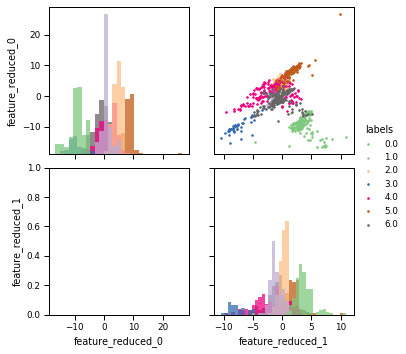

In [48]:
P.scatter_PDF(var_name = var_name + '_reduced')
P.save_BlueCloud('figures/scatter_PDF_EX.png')

__BIC__

In [49]:
corr_dist = 70 # correlation distance in km
Nrun = 10 # number of runs for each k
NK = 20 # max number of classes to explore

In [50]:
BIC, BIC_min = BIC_calculation(X=X, coords_dict={'latitude':'lat', 'longitude':'lon'}, 
                               corr_dist=corr_dist,
                               feature_name='feature_reduced', var_name= var_name + "_reduced",
                               Nrun=Nrun, NK=NK)

Figure saved in figures/BIC_EX.png


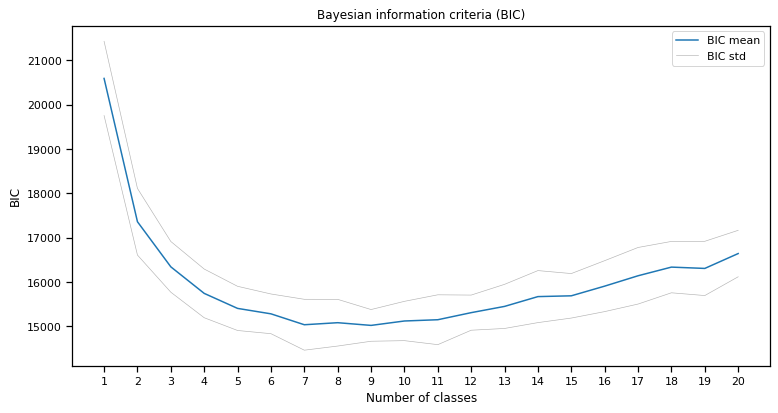

In [51]:
plot_BIC(BIC, NK=NK)
P.save_BlueCloud('figures/BIC_EX.png', bic_fig='yes')

## Plot results
***

In [52]:
P = Plotter_OR(ds_labels, model)

#### __1) Quantiles time series__

Median and other quantiles representation

Figure saved in figures/tseries_struc_EX.png


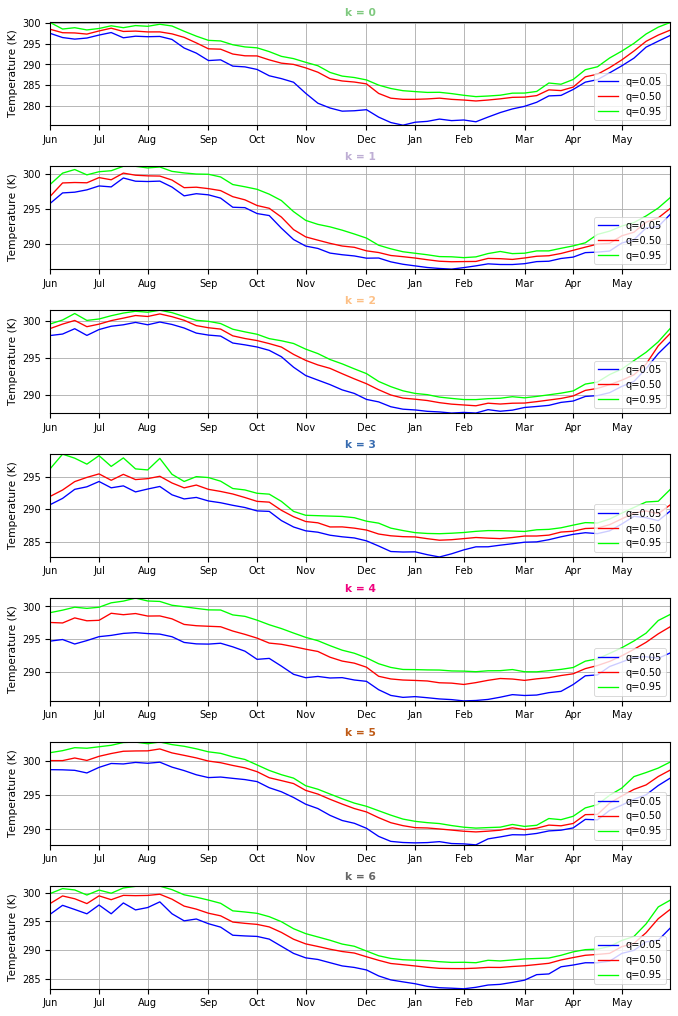

In [53]:
P.tseries_structure(q_variable = var_name + '_Q', start_month=6, ylabel='Temperature (K)')
P.save_BlueCloud('figures/tseries_struc_EX.png')

All median time series in the same plot 

Figure saved in figures/tseries_struc_comp_EX.png


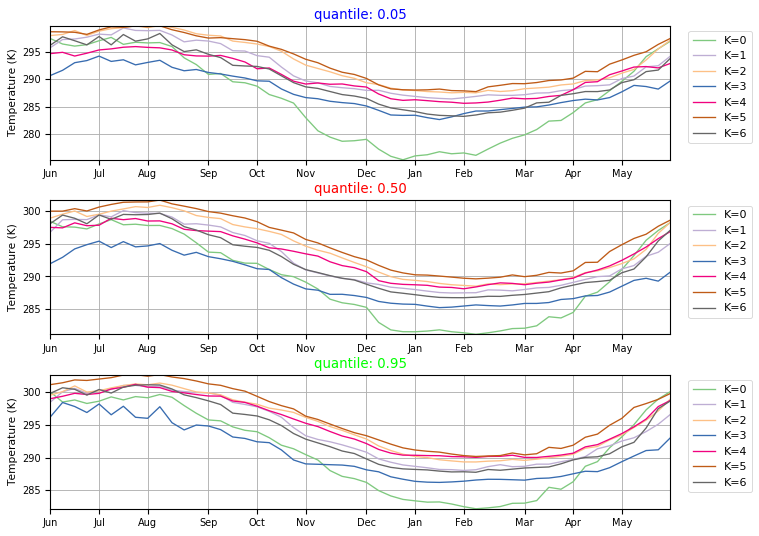

In [54]:
P.tseries_structure_comp(q_variable = var_name + '_Q', plot_q= 'all', ylabel='Temperature (K)', start_month=6)
P.save_BlueCloud('figures/tseries_struc_comp_EX.png')

Quantiles when temperature is scaled (__how we can interpret this figure?__)

Figure saved in figures/tseries_struc_EX_norm.png


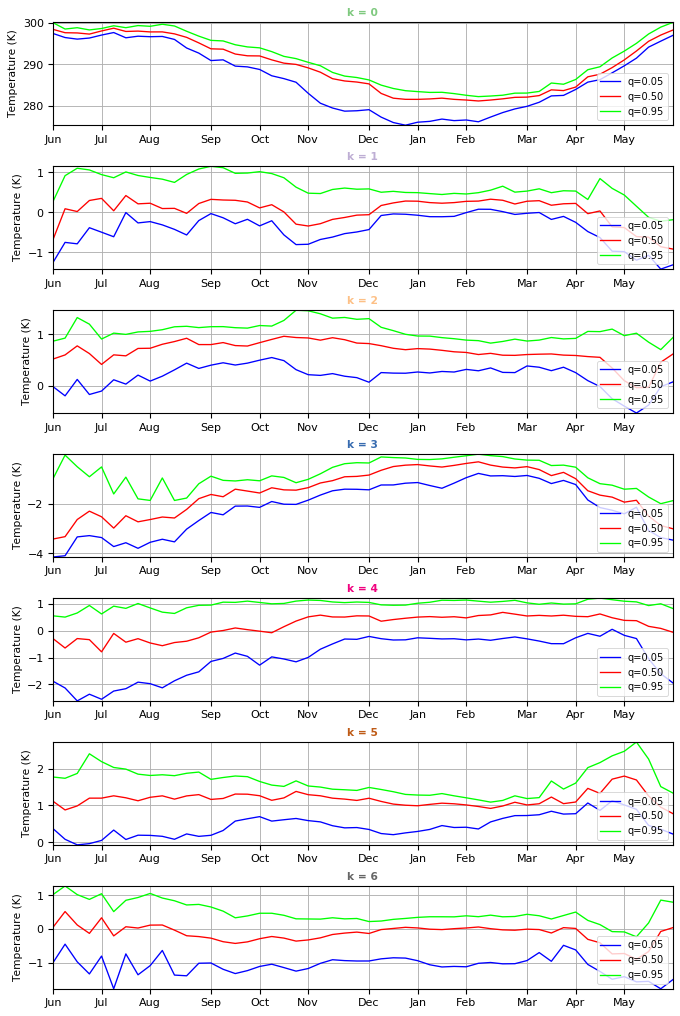

In [55]:
P.tseries_structure(q_variable = var_name + '_scaled' + '_Q', start_month=6, ylabel='Temperature (K)')
P.save_BlueCloud('figures/tseries_struc_EX_norm.png')

#### __2) Spatial distribution of classes__

Figure saved in figures/spatial_distr_EX.png


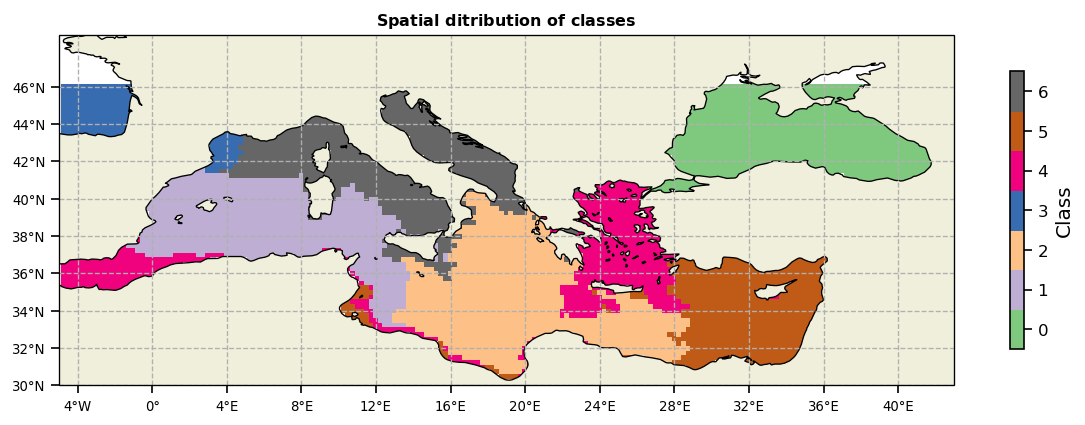

In [56]:
P.spatial_distribution()
P.save_BlueCloud('figures/spatial_distr_EX.png')

#### __3) Robustness__

Figure saved in figures/robustness_EX.png


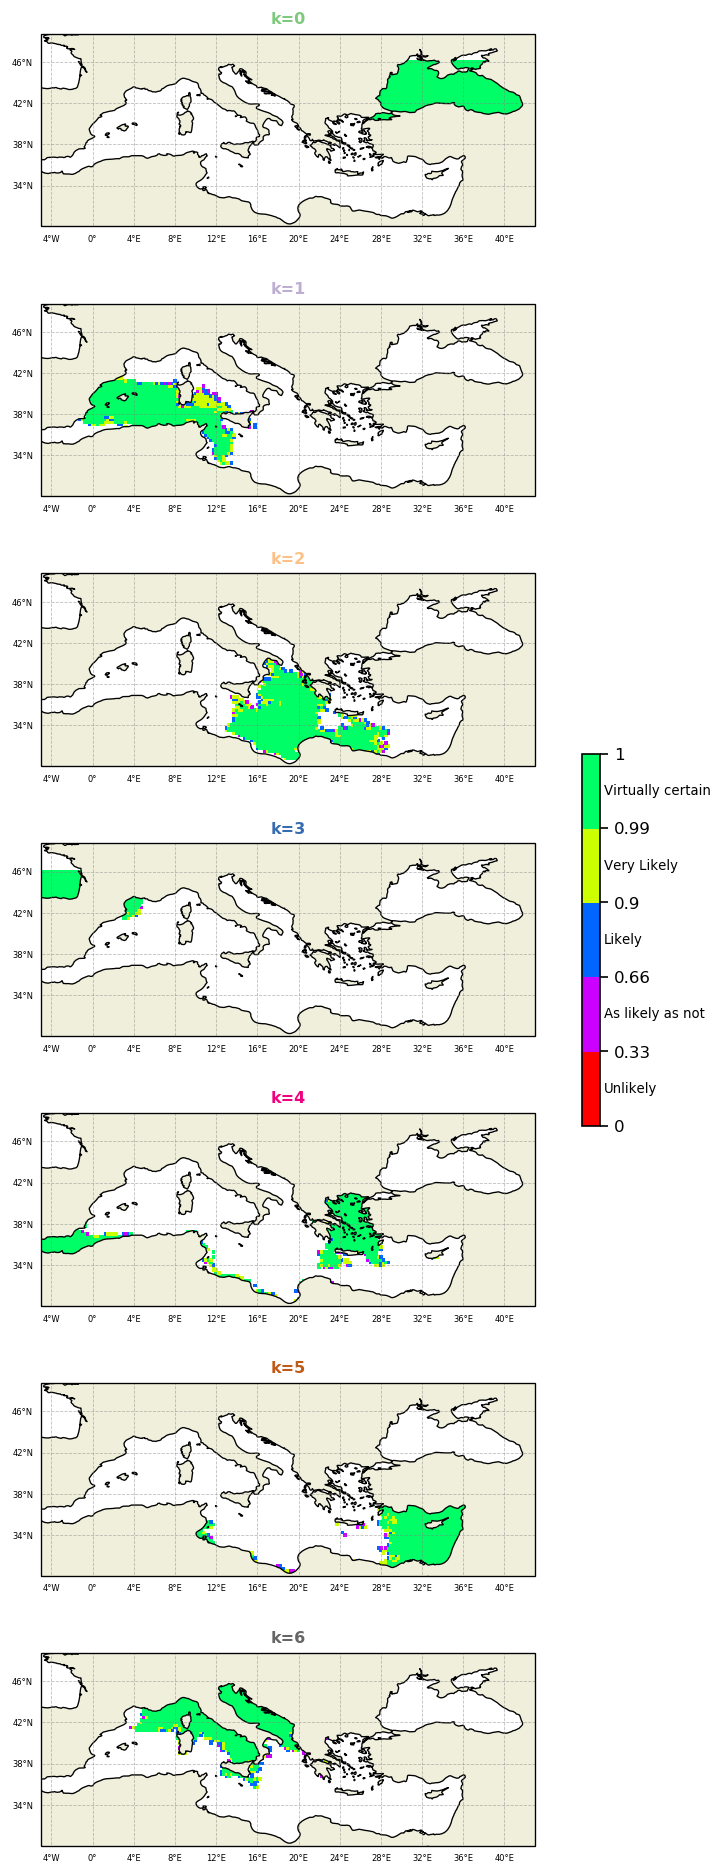

In [57]:
P.plot_robustness()
P.save_BlueCloud('figures/robustness_EX.png')

#### __4) Classes pie chart__

/export/home1/agarciaj_local/home/WORK/JUPYTER-notebooks/BlueCloud/Plotter_OR.py:191: UserWarning: This figure was using constrained_layout==True, but that is incompatible with subplots_adjust and or tight_layout: setting constrained_layout==False. 
  plt.tight_layout()


Figure saved in figures/pie_chart_EX.png


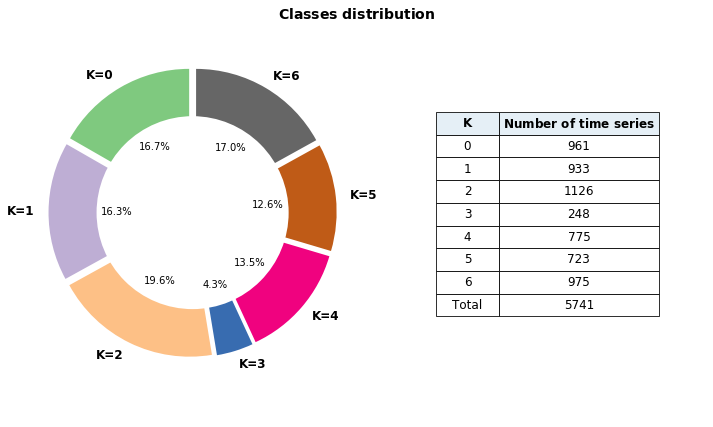

In [58]:
P.pie_classes()
P.save_BlueCloud('figures/pie_chart_EX.png')